# Stress analysis toolbox

This notebook shows how to run a comprehensive analysis of droplets with napari-stress.

In [1]:
import napari
from napari_stress import measurements
import napari_stress
from napari.layers import Layer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np

import tqdm

As an example dataset, we will use the data provided by napari-stress for this tutorial. However, any 4D/3D pointcloud of a reconstructed surface is applicable.

In [2]:
pointcloud = napari_stress.get_droplet_point_cloud_4d()[0]

*Note*: Note that the `get_droplet_point_cloud_4d` function returns a [LayerDataTuple](https://napari.org/stable/guides/magicgui.html). This is structured as follows:
* `pointcloud[0]`: The point data
* `**pointcloud[1]`: Some additional properties of no additional relevance - they just make a nice display and can be omitted. For more information, see the [napari documentation](https://napari.org/stable/howtos/layers/points.html).'

In [3]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_points(pointcloud[0], **pointcloud[1])

Assistant skips harvesting pyclesperanto as it's not installed.


<Points layer 'Points' at 0x140f1d4eb80>

## Running the analysis

To run the analysis, simply use the `measurements.conprehensive_analysis()` function and pass the point coordinates to it:

In [22]:
results = measurements.comprehensive_analysis(pointcloud[0], n_quadrature_points=484)

The `results` variable now contains all the resulting napari layers, again stored as a `LayerDataTuple`. Each of these can be converted to a Layer and added to the napari viewer:

In [23]:
results[0]

(array([[ 0.        ,  6.95775623, 13.45595004, 19.36932656],
        [ 0.        ,  7.05698064, 13.01970372, 18.02812987],
        [ 0.        ,  7.46054991, 12.27570894, 18.99690873],
        ...,
        [20.        , 24.05756029, 11.8054935 , 12.00718916],
        [20.        , 24.14591354, 11.57966183, 13.2761261 ],
        [20.        , 24.42030454, 10.04143419, 12.98943788]]),
 {'name': 'Result of fit spherical harmonics (deg = 5',
  'features': {'fit_residue': array([0.03914378, 0.0401572 , 0.05960514, ..., 0.05496278, 0.04690556,
          0.09254964])},
  'face_colormap': 'inferno',
  'face_color': 'fit_residue',
  'size': 0.5},
 'points')

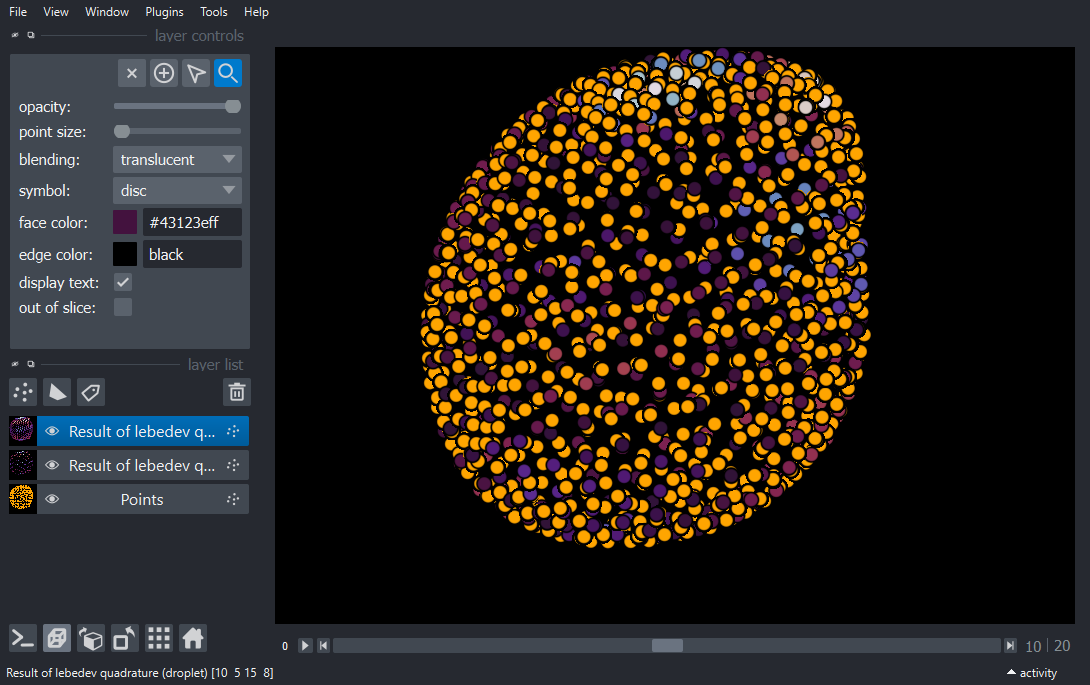

In [24]:
results_layer = Layer.create(data = results[-1][0], meta=results[-1][1], layer_type=results[-1][2])
viewer.add_layer(results_layer)
napari.utils.nbscreenshot(viewer)

## Analyse the results

Running the analysis from code allows  more in-depth exploration of the acquired measurements, which will be explained here.

In [25]:
# Some settings:
cmap = cm.twilight
n_frames = int(results[0][0][:,0].max())
n_frames

20

In [38]:
def histogram_over_time(frames, feature, nbins=50, **kwargs):
    """Create histogram plots over time"""
    n_frames = int(frames.max())
    
    fig, ax = plt.subplots(figsize=(10,10))
    for index in tqdm.tqdm(range(n_frames)):
        subset = feature[np.argwhere(frame_indeces == index).squeeze()]
        hist = np.histogram(subset, nbins)
        ax.plot(hist[0], label=f'Timepoint: {index}', color=cmap(index/n_frames), linewidth=2,**kwargs)

    ax.legend()
    ax.set_ylabel('Occurrences [#]')
    
    return fig, ax

### Fit residues

The fit residues denote the euclidian distances between the fitted points and the raw pointcloud

#### Ellipsoid

In [39]:
fitted_ellipsoid_points = results[1]
fitted_ellipsoid_points[1]['features'].keys()

dict_keys(['fit_residue'])

In [40]:
features = fitted_ellipsoid_points[1]['features']

Cumulatively for all timepoints:

Text(0, 0.5, 'Occurrences')

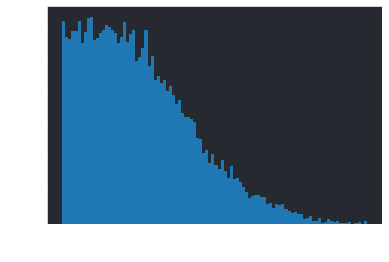

In [41]:
fig, ax = plt.subplots()
ax.hist(features['fit_residue'], 100)
ax.set_xlabel('Fit residue')
ax.set_ylabel('Occurrences')

Separately for every timepoint:

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1280.00it/s]


Text(0.5, 1.0, 'Ellipsoid fit residuals')

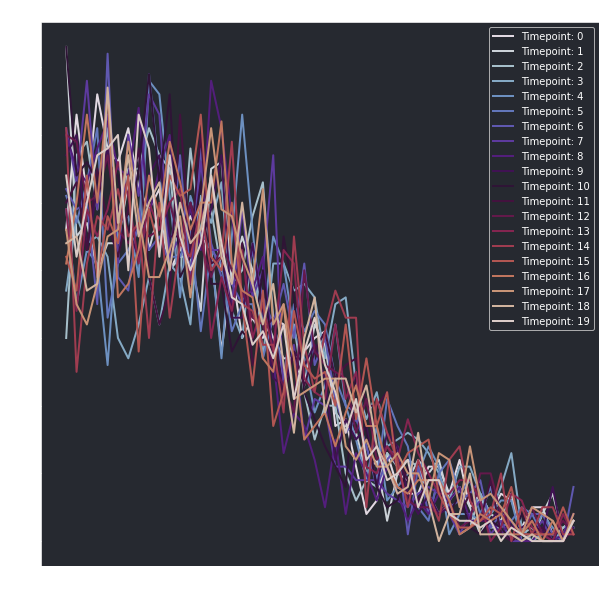

In [42]:
frame_indeces = fitted_ellipsoid_points[0][:,0]
fig, ax = histogram_over_time(frame_indeces, features['fit_residue'])
ax.set_xlabel('Fit residue')
ax.set_title('Ellipsoid fit residuals')

#### Spherical harmonics

In [ ]:
fitted_ellipsoid_points = results[0]
fitted_ellipsoid_points[1]['features'].keys()

In [54]:
features = fitted_ellipsoid_points[1]['features']

Cumulatively for all timepoints:

Text(0, 0.5, 'Occurrences')

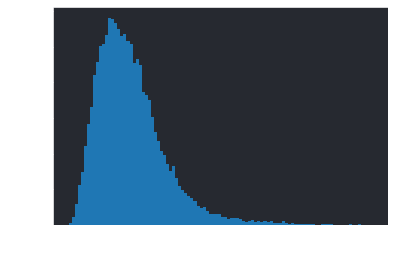

In [55]:
fig, ax = plt.subplots()
ax.hist(features['fit_residue'], 100)
ax.set_xlabel('Fit residue')
ax.set_ylabel('Occurrences')

Separately for every timepoint:

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1330.11it/s]


Text(0.5, 1.0, 'Spherical harmonics fit residuals')

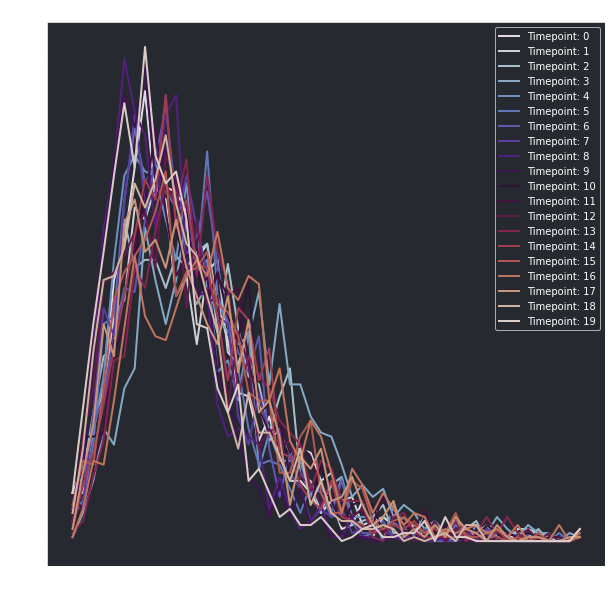

In [56]:
frame_indeces = fitted_ellipsoid_points[0][:,0]
fig, ax = histogram_over_time(frame_indeces, features['fit_residue'])
ax.set_xlabel('Fit residue')
ax.set_title('Spherical harmonics fit residuals')

## Gauss-Bonnet test

In [60]:
layer_quadrature = results[-1]
layer_quadrature[1]['metadata']['Gauss_Bonnet_error']

4.800271593552452e-07

## Stresses

Retrieve the anisotropic stresses as follows:

### Total anisotropic stress

In [47]:
layer_quadrature = results[-1]
layer_quadrature[1]['features'].keys()

dict_keys(['mean_curvature', 'anisotropic_stress_cell', 'anisotropic_stress'])

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 988.59it/s]


Text(0.5, 1.0, 'anisotropic_stress')

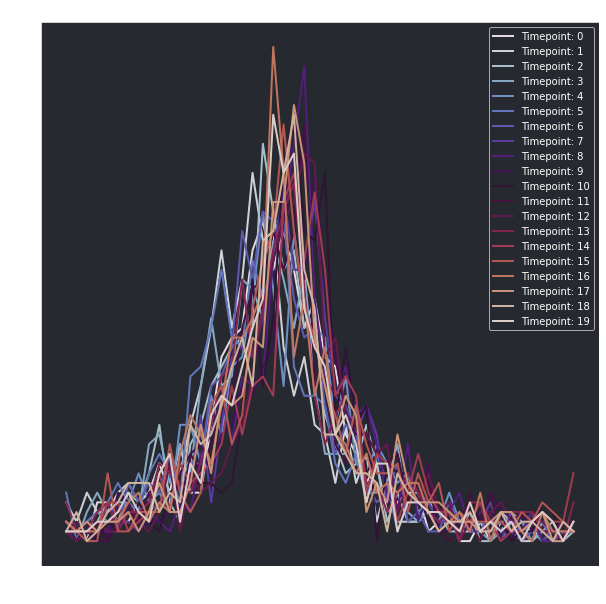

In [48]:
frame_indeces = layer_quadrature[0][:,0]
features = layer_quadrature[1]['features']

fig, ax = histogram_over_time(frame_indeces, features['anisotropic_stress'])
ax.set_xlabel('anisotropic stress [mN/m]')
ax.set_title('anisotropic_stress')

### Anisotropic cell-scale stress

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1277.74it/s]


Text(0.5, 1.0, 'anisotropic_stress_cell')

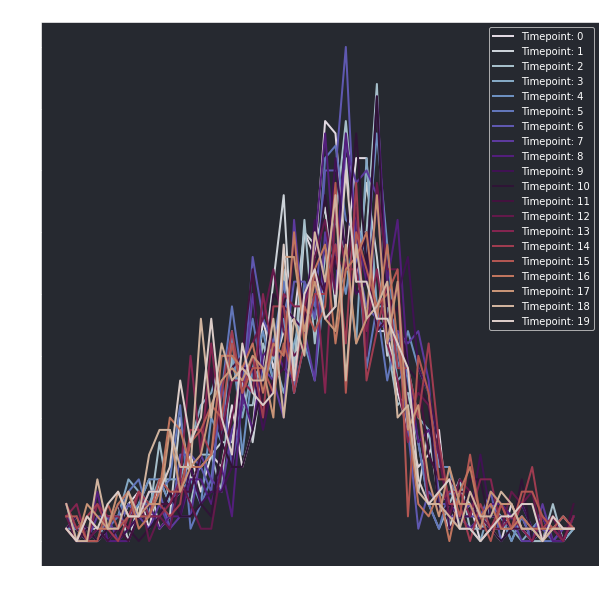

In [49]:
frame_indeces = layer_quadrature[0][:,0]
features = layer_quadrature[1]['features']

fig, ax = histogram_over_time(frame_indeces, features['anisotropic_stress_cell'])
ax.set_xlabel('anisotropic stress [mN/m]')
ax.set_title('anisotropic_stress_cell')

### Anisotropic tissue-scale stress

In [50]:
layer_quadrature_ellipsoid = results[3]
layer_quadrature_ellipsoid[1]['features'].keys()

dict_keys(['anisotropic_stress_tissue'])

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1073.11it/s]


Text(0.5, 1.0, 'anisotropic_stress_tissue')

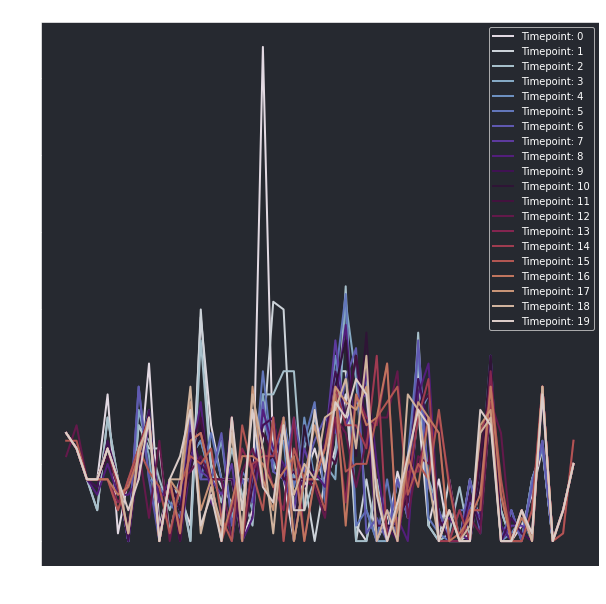

In [52]:
frame_indeces = layer_quadrature_ellipsoid[0][:,0]
features = layer_quadrature_ellipsoid[1]['features']

fig, ax = histogram_over_time(frame_indeces, features['anisotropic_stress_tissue'])
ax.set_xlabel('anisotropic stress [mN/m]')
ax.set_title('anisotropic_stress_tissue')